# Artigo 7
* Aluno: Paulo Henrique Costa Gontijo
* Matrícula: 15/0143800
* Lição: **
* Notebooks: 
  * **
  * **

| Hitórico de versão | Data |
|:--------------------:|:------:|
| v1 | 24/01/2023 |

## Propósito
Este artigo tem a intenção de documentar o passo a passo da quarta lição do curso, mostrando os blocos de códigos, o resultado das execuções, eventuais problemas encontrados e, se houver, as possíveis soluções para os problemas.

## Tema
A lição X do curso FastAi

> Caso tenha problemas para ver os gráficos, acesse este link para [nbviewer](https://nbviewer.org/github/paulohgontijoo/fastaiOnCampus/blob/main/artigos/lesson-7/150143800_paulohgontijoo_Paulo_Henrique_Costa_Gontijo.ipynb).

In [1]:
import fastbook
fastbook.setup_book()

## Importação das Bibliotecas

In [2]:
import os
import pandas as pd

file_name = 'train.jsonl'
file_path = '/'.join([os.getcwd(), file_name])

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
from os.path import abspath

warehouse_location = abspath('spark-warehouse')

    # init session
spark = SparkSession \
        .builder \
        .appName("otto-reccomender-competition-kaggle") \
        .config("spark.sql.warehouse.dir", abspath('spark-warehouse')) \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "true")\
        .config("spark.driver.maxResultSize", "20g")\
        .enableHiveSupport() \
        .getOrCreate()

# show configured parameters
print(SparkConf().getAll())

# set log level
spark.sparkContext.setLogLevel("WARN")

23/01/25 22:03:13 WARN Utils: Your hostname, gobellek-B660M-DS3H-DDR4 resolves to a loopback address: 127.0.1.1; using 192.168.0.37 instead (on interface enp3s0)
23/01/25 22:03:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/25 22:03:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
[('spark.app.submitTime', '1674694994118'), ('spark.app.name', 'otto-reccomender-competition-kaggle'), ('spark.sql.execution.arrow.pyspark.fallback.enabled', 'true'), ('spark.sql.catalogImplementation', 'hive'), ('spark.driver.maxResultSize', '20g'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.submit.deployMode', 'client'), ('spark.sql.warehouse.dir', '/home/gobellek/Documents/UnB/mlops/fastaiOnCampus/artigos/lesson-7/spark-warehouse'), ('spark.ui.showConsoleProgress', 'true'), ('spark.sql.execution.arrow.pyspark.enabled', 'true')]


In [4]:
spark

In [5]:
import pyspark.pandas as ps
ps.set_option('compute.ops_on_diff_frames', True)

In [6]:
df_raw = spark.read \
    .format("json") \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .json(file_path)
df_raw.columns

['events', 'session']

In [7]:
print(df_raw.rdd.getNumPartitions())

85


In [8]:
df_raw.show(10)

+--------------------+-------+
|              events|session|
+--------------------+-------+
|[{1517085, 165930...|      0|
|[{424964, 1659304...|      1|
|[{763743, 1659304...|      2|
|[{1425967, 165930...|      3|
|[{613619, 1659304...|      4|
|[{1098089, 165930...|      5|
|[{137164, 1659304...|      6|
|[{87774, 16593048...|      7|
|[{1814223, 165930...|      8|
|[{847707, 1659304...|      9|
+--------------------+-------+
only showing top 10 rows



In [9]:
df_raw.count()

12899779

In [10]:
df_raw.printSchema()

root
 |-- events: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- aid: long (nullable = true)
 |    |    |-- ts: long (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- session: long (nullable = true)



In [11]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
df_explode = df_raw.withColumn('events_explode', F.explode('events'))\
                    .withColumn('session', F.col('session').cast(T.IntegerType()))\
                    .withColumn('aid', F.col('events_explode.aid').cast(T.IntegerType()))\
                    .withColumn('ts', F.col('events_explode.ts'))\
                    .withColumn('type', F.col('events_explode.type'))\
                    .drop('events', 'events_explode')
df_explode.show(10)

+-------+-------+-------------+------+
|session|    aid|           ts|  type|
+-------+-------+-------------+------+
|      0|1517085|1659304800025|clicks|
|      0|1563459|1659304904511|clicks|
|      0|1309446|1659367439426|clicks|
|      0|  16246|1659367719997|clicks|
|      0|1781822|1659367871344|clicks|
|      0|1152674|1659367885796|clicks|
|      0|1649869|1659369893840| carts|
|      0| 461689|1659369898050| carts|
|      0| 305831|1659370027105|orders|
|      0| 461689|1659370027105|orders|
+-------+-------+-------------+------+
only showing top 10 rows



In [12]:
df_explode.count()

216716096

In [13]:
df_explode.printSchema()

root
 |-- session: integer (nullable = true)
 |-- aid: integer (nullable = true)
 |-- ts: long (nullable = true)
 |-- type: string (nullable = true)



In [14]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='type', outputCol='type_cat')
indexer_fitted = indexer.fit(df_explode)
df_indexed = indexer_fitted.transform(df_explode)
df_indexed = df_indexed.withColumn('type_cat', F.col('type_cat').cast(T.IntegerType())).drop('type')
df_indexed.show(10)

+-------+-------+-------------+--------+
|session|    aid|           ts|type_cat|
+-------+-------+-------------+--------+
|      0|1517085|1659304800025|       0|
|      0|1563459|1659304904511|       0|
|      0|1309446|1659367439426|       0|
|      0|  16246|1659367719997|       0|
|      0|1781822|1659367871344|       0|
|      0|1152674|1659367885796|       0|
|      0|1649869|1659369893840|       1|
|      0| 461689|1659369898050|       1|
|      0| 305831|1659370027105|       2|
|      0| 461689|1659370027105|       2|
+-------+-------+-------------+--------+
only showing top 10 rows



In [15]:
df_indexed.printSchema()

root
 |-- session: integer (nullable = true)
 |-- aid: integer (nullable = true)
 |-- ts: long (nullable = true)
 |-- type_cat: integer (nullable = true)



In [16]:
df_indexed.describe().show()

+-------+-----------------+-----------------+--------------------+-------------------+
|summary|          session|              aid|                  ts|           type_cat|
+-------+-----------------+-----------------+--------------------+-------------------+
|  count|        216716096|        216716096|           216716096|          216716096|
|   mean|4702787.036247751|928805.2291050315|1.660533052633671...|0.12502113825453925|
| stddev|3664999.505174937|536691.7477821864| 6.961450277103137E8|0.39553426995921603|
|    min|                0|                0|       1659304800025|                  0|
|    max|         12899778|          1855602|       1661723999984|                  2|
+-------+-----------------+-----------------+--------------------+-------------------+



In [17]:
from pyspark.sql.window import Window
windowSpec  = Window.partitionBy("session").orderBy(F.col("ts").asc())
df_lag = df_indexed.withColumn("aid_shift",F.lag("aid",-1).over(windowSpec))
df_lag = df_indexed.withColumn("type_cat_shift",F.lag("type_cat",-1).over(windowSpec))
df_lag.show(10)

+-------+-------+-------------+--------+--------------+
|session|    aid|           ts|type_cat|type_cat_shift|
+-------+-------+-------------+--------+--------------+
|     31| 345693|1659304800492|       0|             0|
|     31|  33118|1659304813824|       0|             0|
|     31| 208146|1659304918011|       0|             0|
|     31| 360813|1659305016995|       0|             0|
|     31|1468793|1659305042993|       0|             0|
|     31|1269912|1659305184073|       0|          null|
|     85| 578262|1659304801249|       0|             0|
|     85|1031830|1659304813663|       0|             0|
|     85| 852259|1659304849591|       0|             0|
|     85|1018892|1659553248642|       0|             0|
+-------+-------+-------------+--------+--------------+
only showing top 10 rows



## Análise de Clientes

* Quantidade de clientes únicos

In [18]:
df_lag.select('session').distinct().count()

12899779

* Clientes que mais interagiram

In [19]:
df_lag.groupby(df_lag.session).agg(F.count("*").alias('count')).orderBy(F.col("count").desc()).show()

+--------+-----+
| session|count|
+--------+-----+
| 4110619|  500|
| 6265682|  500|
| 1870739|  499|
|10776795|  499|
|11361393|  498|
|  715022|  498|
|  352795|  498|
| 2473055|  498|
| 5611645|  497|
| 3043807|  497|
| 1637995|  497|
|  584209|  497|
| 1166020|  497|
| 1005706|  496|
|    7905|  495|
| 1181850|  495|
| 2310563|  495|
| 4127525|  495|
| 2464306|  495|
|  767281|  495|
+--------+-----+
only showing top 20 rows



* Clientes que mais compraram

In [20]:
df_lag.filter("type_cat==2").groupBy('session').agg(F.count('type_cat').alias('count')).orderBy(F.col('count').desc()).show()

+-------+-----+
|session|count|
+-------+-----+
| 632727|  117|
|6247320|  103|
| 473286|  100|
| 537589|   98|
|5408461|   94|
| 928030|   91|
| 270870|   91|
|6118385|   90|
|  29693|   89|
| 125743|   88|
| 229448|   88|
|2077637|   87|
| 521545|   86|
|8643943|   86|
|1471672|   85|
|2845568|   85|
|6691353|   85|
|5530900|   83|
|1572771|   81|
|1401588|   81|
+-------+-----+
only showing top 20 rows



## Análise de Produtos

* Quantidade de produtos únicos

In [21]:
df_lag.select('aid').distinct().count()

1855603

* Produtos mais comprados

In [22]:
df_lag.filter("type_cat==2").groupBy('aid').agg(F.count('*').alias('count')).orderBy(F.col('count').desc()).show()

+-------+-----+
|    aid|count|
+-------+-----+
| 231487| 4485|
| 166037| 3824|
|1733943| 3042|
|1445562| 2998|
|1022566| 2788|
| 801774| 2710|
|1629608| 2628|
| 756588| 2593|
| 332654| 2436|
|1603001| 2353|
| 409620| 2329|
|1257293| 2273|
|1125638| 2203|
| 986164| 2192|
|1083665| 2174|
| 450505| 2137|
| 544144| 2096|
|1025795| 2071|
| 125278| 2047|
|  29735| 2007|
+-------+-----+
only showing top 20 rows



* Produtos mais colocados em carrinho

In [23]:
df_lag.filter("type_cat==1").groupBy('aid').agg(F.count('*').alias('count')).orderBy(F.col('count').desc()).show()

+-------+-----+
|    aid|count|
+-------+-----+
| 485256|29682|
| 152547|18536|
|  33343|14726|
| 166037|13476|
|1733943|10654|
| 231487|10393|
|  29735|10124|
|1022566| 9338|
| 832192| 8626|
| 544144| 7407|
| 554660| 7336|
| 322370| 7298|
|1562705| 7128|
| 986164| 7005|
|1083665| 6734|
| 332654| 6679|
|1629608| 6659|
|1236775| 6224|
| 756588| 6166|
| 613493| 6111|
+-------+-----+
only showing top 20 rows



* Produtos mais clicados

In [24]:
df_lag.filter("type_cat==1").groupBy('aid').agg(F.count('*').alias('count')).orderBy(F.col('count').desc()).show()

+-------+-----+
|    aid|count|
+-------+-----+
| 485256|29682|
| 152547|18536|
|  33343|14726|
| 166037|13476|
|1733943|10654|
| 231487|10393|
|  29735|10124|
|1022566| 9338|
| 832192| 8626|
| 544144| 7407|
| 554660| 7336|
| 322370| 7298|
|1562705| 7128|
| 986164| 7005|
|1083665| 6734|
| 332654| 6679|
|1629608| 6659|
|1236775| 6224|
| 756588| 6166|
| 613493| 6111|
+-------+-----+
only showing top 20 rows



In [25]:
# df_write.coalesce(2)\
#         .write.format('csv')\
#         .option("header", "True")\
#         .mode("overwrite")\
#         .save('/'.join([os.getcwd(), 'train.csv']))

## Carregamento dos Dados 
Utilizando a classe **TabularPandas**, a fim de criar o bloco de dados insumo para treinamento do modelo. As variáveis definidas abaixo significam:

* `y_names`: Coluna alvo de regressão.
* `cat_names`: Coluna de variáveis categóricas, caso existissem no exemplo.
* `cont_names`: Coluna de variáveis contínuas, ou seja, estão em formato numérico.
* `splits`: representa uma função de segregação das vases de teste e validação, aplicando a proporção passada em *valid_pct*.


In [28]:
dir_path = '/'.join([os.getcwd(),'train.csv'])
list_files = []
for path in os.scandir(dir_path):
    if path.is_file():
        list_files.append(path.name)
list_files

['_SUCCESS',
 'part-00000-7675d192-1ed1-4573-a9c8-1401d41100ac-c000.csv',
 '._SUCCESS.crc',
 '.part-00000-7675d192-1ed1-4573-a9c8-1401d41100ac-c000.csv.crc']

In [29]:
path = '/'.join([os.getcwd(),'train.csv',list_files[1]])
df = pd.read_csv(filepath_or_buffer=path, nrows=100000)

In [30]:
df.mode().iloc[0]

session      6.675500e+04
aid          3.368840e+05
ts           1.659339e+12
type_cat     0.000000e+00
aid_shift    3.368840e+05
Name: 0, dtype: float64

In [31]:
df = df.fillna(df.mode().iloc[0])
df['aid_shift'] = df['aid_shift'].astype(int)
df

,session,aid,ts,type_cat,aid_shift
0,31,345693,1659304800492,0,33118
1,31,33118,1659304813824,0,208146
2,31,208146,1659304918011,0,360813
3,31,360813,1659305016995,0,1468793
4,31,1468793,1659305042993,0,1269912
...,...,...,...,...,...
99995,94283,1162574,1660597710143,0,1162574
99996,94283,1162574,1660597720888,0,1001783
99997,94283,1001783,1660597732968,0,1190130
99998,94283,1190130,1660597841299,0,1190130


In [36]:
from fastai.tabular.all import *
from fastai.tabular.core import FillMissing
from fastai.tabular.learner import *
from fastbook import *

y_names = ['aid_shift']
procs = [Normalize]
cat_names = []
cont_names = ['session', 'aid', 'ts', 'type_cat']
splits = RandomSplitter(valid_pct=0.3)(range_of(df))
splits

((#70000) [67990,69362,46432,15711,22659,2924,28253,90238,24659,75870...],
 (#30000) [44206,62312,76867,87374,16553,49315,82684,4050,1717,36290...])

In [37]:
to = TabularPandas(df=df,
                   procs=procs,
                   cont_names=cont_names,
                   y_names=y_names, 
                   y_block=RegressionBlock(),
                   splits=splits)
to

        session       aid        ts  type_cat  aid_shift
67990  0.606642 -0.802275 -0.775993 -0.289892     495779
69362  0.655861 -0.113615  1.103378 -0.289892    1428694
46432 -0.122576  1.092383 -1.265662 -0.289892    1514887
15711 -1.217488 -1.594342  1.426502 -0.289892     700490
22659 -0.924739  0.405277 -0.585419 -0.289892    1145303
...         ...       ...       ...       ...        ...
73084  0.758776  0.315120  0.447363 -0.289892     491866
4526  -1.574442  1.352418  1.474573  5.406228    1654756
90783  1.444662 -1.657335 -0.378283 -0.289892     730400
37465 -0.358307 -0.776031  1.714605 -0.289892     742592
63764  0.473322  1.552708 -0.106090  2.558168    1762489

[100000 rows x 5 columns]

## Conferindo o carregamento

In [38]:
dls = to.dataloaders()
print('Valid')
dls.valid.show_batch()
print('Train')
dls.train.show_batch()

Valid


,session,aid,ts,type_cat,aid_shift
0,40385.999984,1.545443e+06,1.661212e+12,-2.389009e-10,651650.0
1,57513.000336,1.421870e+05,1.659615e+12,-2.389009e-10,1308375.0
2,69340.000180,1.761172e+06,1.660936e+12,-2.389009e-10,98077.0
3,82582.000115,2.442803e+04,1.661537e+12,-2.389009e-10,1326443.0
4,12610.999681,1.566993e+06,1.659562e+12,-2.389009e-10,1388637.0
5,44821.999956,8.396560e+05,1.659720e+12,-2.389009e-10,762602.0
6,76083.000914,2.692598e+04,1.659621e+12,-2.389009e-10,1292944.0
7,1902.999204,1.558874e+06,1.660118e+12,-2.389009e-10,1558874.0
8,1024.999734,1.538390e+06,1.659941e+12,-2.389009e-10,881520.0
9,34060.999915,1.730469e+06,1.660574e+12,-2.389009e-10,624327.0


Train


,session,aid,ts,type_cat,aid_shift
0,148.000535,1.683530e+06,1.659309e+12,-2.389009e-10,209445.0
1,61501.000515,1.509935e+06,1.661719e+12,-2.389009e-10,231291.0
2,7993.000171,1.699932e+06,1.661190e+12,-2.389009e-10,1281746.0
3,23867.999894,6.820010e+05,1.659808e+12,1.000000e+00,1760550.0
4,57177.999807,9.853991e+03,1.659311e+12,-2.389009e-10,883758.0
5,74851.998530,6.363900e+05,1.661590e+12,-2.389009e-10,508883.0
6,21121.000674,4.761250e+05,1.661117e+12,-2.389009e-10,476125.0
7,18944.000260,1.353784e+06,1.659308e+12,-2.389009e-10,607027.0
8,62541.999446,1.185490e+06,1.659312e+12,-2.389009e-10,1483049.0
9,36705.999644,5.127110e+05,1.659497e+12,-2.389009e-10,1749332.0


## Definindo range alvo
É importante passar para a função um range alvo da variável que deseja fazer a regressão. Para tal, definimos *tensors* - estrutura original da biblioteca **PyTorch**, a qual se assemelha com uma estrutura **numpy**. 

> Caso a estrutura de tensores mostrada não seja aplicada, provavelmente a função não executará o treinamento de forma correta.

* A lógica por trás da definição do range, envolve em captar a maior e menor variação de preço, já vista no ativo, adicionando o devio padrão e multiplicando este peso ao último valor do dataset.

In [45]:
# y_range = (torch.tensor(min).cuda(), torch.tensor(max).cuda())
y_range = (torch.tensor(df.aid.unique()).squeeze())
y_range

tensor([ 345693,   33118,  208146,  ..., 1162574, 1001783, 1190130])

## Definindo metricas de treinamento
Todas as métricas em comentário foram testadas e, algumas combinações de função de loss e métricas performaram melhor. Em destaque `SpearmanCorrCoef` foi uma das que mais performaram.

In [46]:
#mse
#rmse
#mae
#msle
#exp_rmspe
#ExplainedVariance()
#R2Score()
#PearsonCorrCoef()
#SpearmanCorrCoef()
#loss_func=MSELossFlat()
#loss_func=L1LossFlat()
#DiceLoss()
# learn = None
learn = None
learn = tabular_learner(dls, metrics=SpearmanCorrCoef(), loss_func=L1LossFlat())

## Otimizando taxa de aprendizado
Utilizando a função abaixo é possível encontrar a melhor taxa de aprendizado para o gradiente descendente.

SuggestedLRs(slide=6.309573450380412e-07, valley=0.0008317637839354575)


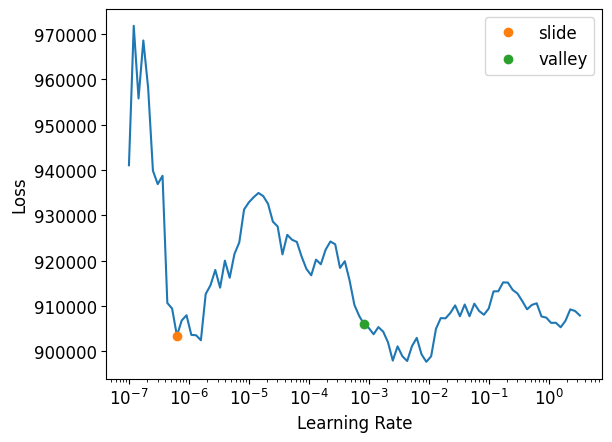

In [47]:
lr_rate = learn.lr_find(suggest_funcs=[slide, valley])
print(lr_rate)

## Treinando o modelo
Utilizando a taxa encontrada e 100 épocas.

In [48]:
lr=(lr_rate[0] + lr_rate[1])/2
print('Learning Rate: ',lr)
learn.fit_flat_cos(10, lr=lr)

Learning Rate:  0.00041619737064024775


epoch,train_loss,valid_loss,spearmanr,time
0,919833.375000,913366.625000,-0.000020,00:04
1,919042.687500,913290.625000,0.140774,00:03
2,912267.500000,913171.937500,0.094502,00:03
3,924301.000000,913011.625000,0.153128,00:05
4,924255.687500,912811.625000,0.133175,00:03
5,923099.875000,912572.875000,0.059278,00:06
6,918316.812500,912304.500000,0.076941,00:03
7,909020.625000,911973.312500,0.086065,00:06
8,911690.125000,911752.687500,0.092922,00:06
9,907440.687500,911709.375000,0.086744,00:03


In [49]:
learn.show_results()

,session,aid,ts,type_cat,aid_shift,aid_shift_pred
0,-0.294283,-1.200217,-1.167776,-0.289892,288733.0,1305.672241
1,-0.761194,-0.290294,-1.046251,-0.289892,1409430.0,1460.167114
2,0.781634,1.000229,0.834962,-0.289892,598308.0,1840.662842
3,-1.501643,0.482065,1.009729,-0.289892,768002.0,1654.806641
4,-1.125658,1.454488,0.867612,-0.289892,650139.0,1658.817383
5,1.284439,-0.410364,0.197171,-0.289892,1689819.0,1713.960327
6,-0.915278,-1.237985,-0.707827,-0.289892,209618.0,957.459961
7,0.165298,0.204892,-1.269175,-0.289892,77019.0,1719.329468
8,-1.217488,-1.594342,1.186647,-0.289892,120468.0,1265.729126


## Validação
Além da validação do framework, valida-se em tempo diferente do treinamento/validação do treinamento do modelo.

In [213]:
test_df = pd.read_csv(filepath_or_buffer=path, nrows=10)
test_df.drop(['aid_shift'], axis=1, inplace=True)
dl = learn.dls.test_dl(test_df)

In [214]:
preds = learn.get_preds(dl=dl)
pred_list = []
for i in range(len(preds[0])): pred_list.append(preds[0][i].numpy()[0])
df_valid = pd.DataFrame(pred_list, index=test_df.index.values, columns=['aid_shift_pred'])
# df_valid['aid_shift'] = test_df['predict_close']
# df_valid['real_close'] = df_valid['aid_shift']
df_valid

,aid_shift_pred
0,20609.628906
1,5652.384277
2,12343.678711
3,21675.001953
4,266311.468750
5,215707.359375
6,49838.472656
7,154395.562500
8,98080.210938
9,136163.781250


## Colaborative Filtering


* Reposicionando colunas

In [52]:
df = df[['session', 'aid', 'type_cat']]

* Carga em CollabDLS

In [105]:
from fastai.collab import *
dls = CollabDataLoaders.from_df(df, item_name='aid', bs=64)
dls.train.show_batch()

,session,aid,type_cat
0,54747,1658561,0
1,69340,915201,0
2,32414,1247601,0
3,58665,300379,0
4,67439,1277509,0
5,17389,696338,0
6,62478,1218102,0
7,37864,520388,0
8,51629,1629866,0
9,5984,1777747,0


In [54]:
dls.classes

{'session': ['#na#', 31, 85, 137, 148, 243, 251, 392, 451, 463, 471, 496, 516, 540, 580, 623, 737, 808, 833, 858, 897, 1025, 1084, 1088, 1127, 1139, 1143, 1238, 1265, 1270, 1303, 1322, 1339, 1342, 1352, 1395, 1460, 1483, 1507, 1522, 1580, 1591, 1618, 1645, 1650, 1699, 1721, 1829, 1884, 1896, 1903, 1959, 1975, 1990, 2025, 2122, 2142, 2231, 2235, 2259, 2366, 2387, 2393, 2443, 2488, 2525, 2563, 2572, 2580, 2659, 2711, 2721, 2748, 2776, 2811, 2821, 2866, 2923, 2996, 2999, 3000, 3089, 3098, 3175, 3179, 3213, 3220, 3226, 3352, 3475, 3488, 3490, 3698, 3704, 3749, 3761, 3794, 3796, 3876, 3918, 3986, 3997, 4042, 4078, 4101, 4158, 4161, 4186, 4190, 4219, 4239, 4364, 4391, 4489, 4519, 4684, 4818, 4900, 4929, 4935, 4937, 5071, 5074, 5117, 5155, 5156, 5173, 5223, 5287, 5300, 5308, 5345, 5482, 5518, 5614, 5803, 5984, 6266, 6336, 6357, 6361, 6393, 6397, 6466, 6482, 6559, 6597, 6598, 6620, 6622, 6623, 6654, 6658, 6773, 6825, 7066, 7098, 7120, 7168, 7240, 7253, 7281, 7340, 7387, 7417, 7530, 7554, 7644,

SuggestedLRs(slide=0.00363078061491251, valley=0.03981071710586548)
Learning Rate:  0.021720748860388994


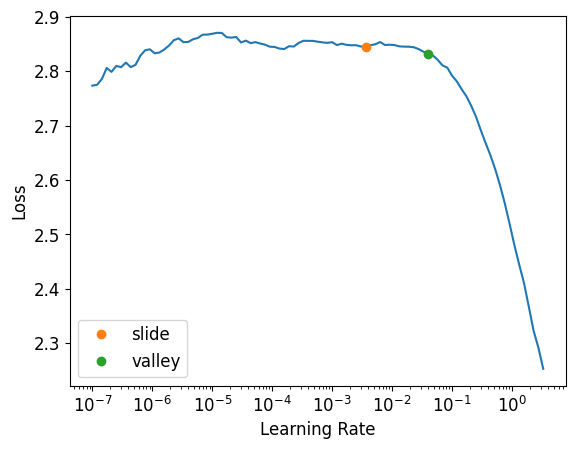

In [55]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 3.5))
lr_rate = learn.lr_find(suggest_funcs=[slide, valley])
print(lr_rate)
lr=(lr_rate[0] + lr_rate[1])/2
print('Learning Rate: ',lr)

In [57]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.150075,0.229133,00:16
1,0.164097,0.231323,00:17
2,0.141206,0.209535,00:17
3,0.105962,0.199641,00:16
4,0.089114,0.202206,00:14


In [61]:
product_bias = learn.model.i_bias.weight.squeeze()
print(product_bias)
idxs = product_bias.argsort(descending=True)[:10]
print(idxs)
[dls.classes['aid'][i] for i in idxs]

tensor([-1.1173e-04, -1.0228e+00, -3.7369e-01,  ..., -5.3659e-01, -3.7458e-01, -1.9647e-01], grad_fn=<SqueezeBackward0>)
tensor([16652, 35150, 19720, 18649, 31123, 34064, 20220, 37191,  3178, 21560])


[809225,
 1702270,
 958090,
 904915,
 1509738,
 1650535,
 980509,
 1802836,
 155374,
 1044108]

In [186]:
top_products = df[df['type_cat'] == 2].drop('type_cat', axis=1).groupby('aid').count().sort_values(by='session',ascending=False).drop('session', axis=1).iloc[:100]
top_products = list(top_products.index)
top_products

[725902,
 1532501,
 1194834,
 1464063,
 1122752,
 1682280,
 260425,
 673407,
 1626731,
 1807644,
 134068,
 543862,
 615771,
 818844,
 636390,
 1232436,
 813208,
 806416,
 660775,
 109382,
 1784036,
 1069364,
 866174,
 332654,
 307249,
 592605,
 1836036,
 809225,
 405022,
 1475890,
 186405,
 402265,
 1471029,
 1280753,
 1275991,
 635464,
 178417,
 433327,
 1726746,
 1286636,
 1077803,
 848164,
 690107,
 633619,
 1724354,
 1694143,
 1084758,
 1701855,
 1702270,
 1083665,
 1239831,
 610448,
 842908,
 834049,
 162064,
 619885,
 1689754,
 1351523,
 399315,
 346199,
 678202,
 1167802,
 728774,
 1537160,
 1211210,
 718019,
 716538,
 346333,
 1569264,
 1482457,
 341908,
 708985,
 310346,
 1562707,
 1561331,
 706703,
 329725,
 697883,
 359626,
 1221484,
 672538,
 750993,
 647577,
 198496,
 200530,
 1650562,
 1746048,
 210931,
 1127933,
 1501332,
 1230740,
 1229383,
 770581,
 1508062,
 1139745,
 1140478,
 1511908,
 372942,
 671142,
 1122211]

In [161]:
product_bias = learn.model.bias(top_products, is_item=True)
product_bias.shape

torch.Size([100])

In [215]:
mean_ratings = df.groupby('aid')['type_cat'].mean()
product_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_products,product_bias)]
product_ratings

[(tensor(-0.0628), 725902, 0.6666666666666666),
 (tensor(-0.0148), 1532501, 0.631578947368421),
 (tensor(-0.7087), 1194834, 0.3409090909090909),
 (tensor(-0.0072), 1464063, 0.7222222222222222),
 (tensor(0.2144), 1122752, 0.7222222222222222),
 (tensor(-0.0530), 1682280, 0.75),
 (tensor(-0.1031), 260425, 0.45454545454545453),
 (tensor(-0.0405), 673407, 0.3902439024390244),
 (tensor(-0.3620), 1626731, 0.5),
 (tensor(0.0403), 1807644, 0.5238095238095238),
 (tensor(0.2786), 134068, 0.75),
 (tensor(-0.0844), 543862, 0.75),
 (tensor(-0.9131), 615771, 0.23684210526315788),
 (tensor(-0.0192), 818844, 0.6666666666666666),
 (tensor(-0.7452), 636390, 0.45454545454545453),
 (tensor(0.3287), 1232436, 0.8181818181818182),
 (tensor(-0.0032), 813208, 0.6666666666666666),
 (tensor(0.0703), 806416, 0.7333333333333333),
 (tensor(-0.0768), 660775, 0.8181818181818182),
 (tensor(-0.3784), 109382, 0.4230769230769231),
 (tensor(-0.6006), 1784036, 0.4444444444444444),
 (tensor(-0.2928), 1069364, 0.4761904761904

In [164]:
sorted(product_ratings, key=lambda o: o[0], reverse=True)[:20]

[(tensor(1.0632), 809225, 1.0),
 (tensor(0.9773), 1702270, 1.3333333333333333),
 (tensor(0.6505), 672538, 1.2),
 (tensor(0.6011), 866174, 1.0),
 (tensor(0.5982), 402265, 1.5),
 (tensor(0.5690), 1482457, 1.2),
 (tensor(0.5574), 610448, 1.0),
 (tensor(0.5215), 750993, 2.0),
 (tensor(0.4671), 1501332, 1.0),
 (tensor(0.4571), 433327, 1.0),
 (tensor(0.4525), 359626, 1.2),
 (tensor(0.4261), 310346, 0.875),
 (tensor(0.4236), 635464, 0.7272727272727273),
 (tensor(0.3945), 1167802, 0.8571428571428571),
 (tensor(0.3289), 848164, 0.75),
 (tensor(0.3287), 1232436, 0.8181818181818182),
 (tensor(0.3203), 1351523, 0.7),
 (tensor(0.2952), 1139745, 1.0),
 (tensor(0.2913), 1077803, 1.2),
 (tensor(0.2786), 134068, 0.75)]

In [203]:
top_users = df[df['type_cat'] == 2].drop('type_cat', axis=1).groupby('session').count().sort_values(by='aid', ascending=False).drop('aid',axis=1).iloc[:100]
top_users = list(top_users.index)
top_users

[32414,
 76187,
 50343,
 32855,
 32988,
 10745,
 84018,
 69340,
 66463,
 137,
 62478,
 21058,
 24663,
 38220,
 42102,
 49308,
 6773,
 91785,
 89056,
 67574,
 55547,
 60068,
 8779,
 68047,
 40439,
 85000,
 68877,
 53172,
 5345,
 36982,
 68098,
 78603,
 50320,
 29811,
 24719,
 88599,
 61230,
 51607,
 36525,
 94265,
 41265,
 28088,
 76701,
 47496,
 19204,
 148,
 43370,
 33722,
 80669,
 84936,
 72702,
 67439,
 93948,
 75877,
 71571,
 29595,
 22107,
 2525,
 43302,
 51629,
 36706,
 40386,
 38298,
 58066,
 48686,
 82115,
 29827,
 91200,
 91678,
 38651,
 15003,
 38656,
 29054,
 58517,
 86406,
 64354,
 44437,
 67388,
 85351,
 84654,
 4519,
 73341,
 90818,
 1650,
 69352,
 37668,
 66755,
 55363,
 92895,
 72254,
 4818,
 89874,
 49503,
 56502,
 38395,
 31872,
 1238,
 14377,
 57513,
 55155]

In [217]:
model = EmbeddingDotBias.from_classes(50, dls.classes,  y_range=(0,5))
model._get_idx(top_users, is_item=False).unsqueeze(1)

tensor([[ 656],
        [1550],
        [1046],
        [ 669],
        [ 672],
        [ 218],
        [1700],
        [1409],
        [1346],
        [   3],
        [1265],
        [ 435],
        [ 501],
        [ 796],
        [ 881],
        [1022],
        [ 152],
        [1848],
        [1792],
        [1370],
        [1141],
        [1228],
        [ 186],
        [1379],
        [ 851],
        [1718],
        [1399],
        [1096],
        [ 130],
        [ 763],
        [1383],
        [1597],
        [1044],
        [ 602],
        [ 504],
        [1785],
        [1241],
        [1073],
        [ 754],
        [1895],
        [ 868],
        [ 568],
        [1561],
        [ 987],
        [ 391],
        [   4],
        [ 903],
        [ 686],
        [1628],
        [1717],
        [1468],
        [1368],
        [1893],
        [1539],
        [1447],
        [ 597],
        [ 454],
        [  64],
        [ 900],
        [1075],
        [ 760],
        [ 850],
        

In [293]:
test_df = pd.read_csv(filepath_or_buffer=path, nrows=10)
test_df.drop(['aid_shift'], axis=1, inplace=True)
dl = learn.dls.test_dl(test_df)

preds = learn.get_preds(dl=dl)
pred_list = []
for i in range(len(preds[0])): pred_list.append(preds[0][i].numpy()[0])
df_valid = pd.DataFrame(pred_list)
# df_valid['aid_shift'] = test_df['predict_close']
# df_valid['real_close'] = df_valid['aid_shift']
df_valid

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
df.aid

In [215]:
data_state(df_valid)

NameError: name 'data_state' is not defined

## Predição

In [23]:
import plotly.express as px
fig = px.line(df_valid, x=df_valid.index.values, y=df_valid.columns)
fig.show()

## Deploy do modelo
O modelo foi implantado no ambiente **HuggingFace**, conforme em outras lições e pode ser acessado por este link: https://huggingface.co/spaces/paulohgontijoo/tabular-fastai-lesson-5

In [27]:
learn.export('./model.pkl')

* Ao executar o comando acima, utilizando a métrica `SpearmenCorrCoef` o seguite erro foi apresentado:

```shell
AttributeError                            Traceback (most recent call last)

<ipython-input-46-da3b055ac77f> in <module>
----> 1 learn.export('/home/model.pkl')

2 frames

/usr/local/lib/python3.8/dist-packages/torch/serialization.py in _save(obj, zip_file, pickle_module, pickle_protocol)
    633     pickler = pickle_module.Pickler(data_buf, protocol=pickle_protocol)
    634     pickler.persistent_id = persistent_id
--> 635     pickler.dump(obj)
    636     data_value = data_buf.getvalue()
    637     zip_file.write_record('data.pkl', data_value, len(data_value))

AttributeError: Can't pickle local object 'SpearmanCorrCoef.<locals>.spearmanr' 
```

* **Solução:** Trocar a métrica para `RMSE`, a qual também performa na solução. 

# Referências Bibliográficas

> https://github.com/Kaggle/kaggle-api

> https://www.youtube.com/watch?v=aBNQzWV_UmE

> https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/968100988546031/157591980591166/8836542754149149/latest.html

> https://blog.clairvoyantsoft.com/apache-spark-out-of-memory-issue-b63c7987fff

> https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_ps.html